# **Muhammad Alif Alfarizi**

#### **1494037162101-564**

Importing libraries

In [1]:
import numpy as np 
import pandas as pd

In [2]:
data_train = pd.read_csv('gold_price_data.csv')
data_train

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [3]:
data_train.isnull().sum()

Date     0
Value    0
dtype: int64

Plot the gold prices

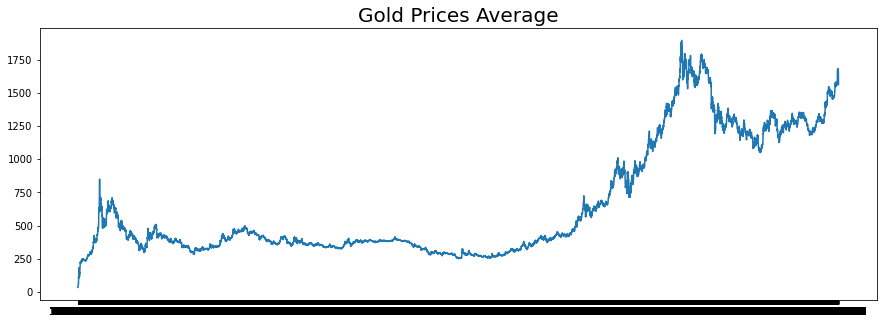

In [6]:
import matplotlib.pyplot as plt
# Extract dates and prices
dates = data_train['Date'].values
prices = data_train['Value'].values

plt.figure(figsize=(15,5))
plt.plot(dates, prices)
plt.title('Gold Prices Average',
          fontsize=20);

Data Preprocessing

In [8]:
data_train = data_train.astype({"Value": float})

In [9]:
data_train.dtypes

Date      object
Value    float64
dtype: object

In [10]:
prices = data_train['Value'].values
prices 

array([  35.2 ,   35.1 ,   35.4 , ..., 1653.75, 1570.7 , 1562.8 ])

In [11]:
prices_new = prices.reshape(-1,1)

Scale the prices using StandardScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
min_max_scaler = StandardScaler()
prices = min_max_scaler.fit_transform(prices_new)

In [13]:
prices = prices.flatten()
prices

array([-1.42484181, -1.42507222, -1.424381  , ...,  2.30444388,
        2.11308916,  2.09488684])

Split the data into train and test sets

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(prices, test_size=0.2, shuffle=False)


In [15]:
X_train.shape 

(8629,)

In [16]:
X_test.shape

(2158,)

Define the windowed dataset function

In [17]:
import tensorflow as tf
from keras.layers import Dense, LSTM

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Model Selection

In [19]:
# Create train and test datasets using the windowed_dataset function
train_set = windowed_dataset(X_train, window_size=60, batch_size=128, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=128, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

MAE Treshold

In [41]:
threshold_mae = (prices.max() - prices.min()) * 10/100
threshold_mae 

0.4285377933239695

Create a custom callback for early stopping

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae):
      print("\nMae telah mencapai standar")
      self.model.stop_training = True
callbacks = myCallback()

Compile the model with Huber loss and SGD optimizer

In [43]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Train the model

In [45]:
history = model.fit(train_set, validation_data=(test_set), epochs=100, callbacks=[callbacks])

Epoch 1/100
     65/Unknown - 2s 23ms/step - loss: 0.0301 - mae: 0.1529
Mae telah mencapai standar
67/67 [==============================] - 2s 29ms/step - loss: 0.0347 - mae: 0.1610 - val_loss: 0.1090 - val_mae: 0.3993
